# Симулятор азартной игры в стиле crash game.

## Правила
 - Игрок делает **ставку** любой суммы на случайный **множитель** от 1.01 до 50. Интерфейс игры позволяет забрать деньги ставку в любой момент, но угадать множитель незлья. На практике будем рассматривать только заранее обдуманное решение игрока.  
 - Выпадает случайный **множитель** число от 0 до 50.
 - С вероятностью **zerosratio** игрок не получает вообще ничего. множитель = 0. Пусть zerosratio = 0.12 .
 - Вероятность выпадения выигрыша обратно пропорциональна его множителю. Неизвестно используемое Организатором распределение, но оно должно быть не доходнее экспонентциального. Вполне, вероятно что наблюдаемое распределение можно приблизить логнормальным или бета-распределением. 
 - Играем всегда фиксированное число ходов. Игра не прекращается если деньги закончились. Если сумма денег отрицательна - это просто долг игрока. Исследовать нужно и эти случаи тоже.

## Цель
 Выработать выигрышную стратегию

## Передположение психологического характера
 Если все игроки склонны ставить  повышенные ставки, то организатор сосредоточен на получении прибыли от них. 
 Тогда игрок обладающий достаточным терпением и суммой, может оказаться в выигрыше.

In [1]:
# набор стандартных библиотек для python
import pandas as pd
import numpy as np
import numba
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import njit, jit
from numpy.random import exponential

Немного более точное значение полученное из наблюдений

In [2]:
zerosratio=0.11929047424763461

# Boostrap 
В этой версии не используется генератор случайных чисел.
Загружаем собранные данные из файла и формируем  из них последовательности желаемого размера. 
Коээфициент zerosratio так же не участвует в расчетах.

In [3]:
df=pd.read_csv('crash_data.tsv', sep='\t',header=None, names=['timestamp','point'],parse_dates= [0],dayfirst=True)
df =df [df.point < 1000] # в данных есть неправдоподобная ошибка. отбросим слишком высокие множители
df.dtypes

timestamp    datetime64[ns]
point               float64
dtype: object

In [4]:
df.head(3)

,timestamp,point
0,2023-03-01 01:27:30,9.17
1,2023-03-01 01:27:38,0.00
2,2023-03-01 01:27:59,4.61


In [5]:
# Здесь немного сложненько:
# чтобы пользоваться njit, нужно чтобы все вызываемые функции тоже были njit. 
# чтобы это все скомпилировалось в numba, придется писать с использованием только numpy 
@njit
def mult_values_bootstrap(size: int,orig_data: np.ndarray) -> np.ndarray:
    return np.random.choice(orig_data,size,replace=True) 

mult_values_bootstrap(5,df.point.to_numpy())

array([2.71, 2.19, 1.18, 1.78, 7.46])

In [6]:
rvalues = mult_values_bootstrap(10000,df.point.to_numpy())
rvalues[:10]

array([2.57, 2.42, 4.97, 4.4 , 2.95, 1.13, 3.72, 2.7 , 3.86, 2.54])

Сравним визуально распределения у выдуманной функции приближения и у данных полученных бутстрапированием.   

In [7]:
# Старая функция с аналитическими коээфициентами:
# 
@njit(parallel=True)
def mult_values_analitics(zerosratio: float,size: int) -> np.ndarray :
    number_of_zeros = round(size*zerosratio)
    result = np.zeros(size)
    result[number_of_zeros:size]=  1+np.random.exponential(scale=2.0, size=size-number_of_zeros)
    np.random.shuffle(result) 
    return result

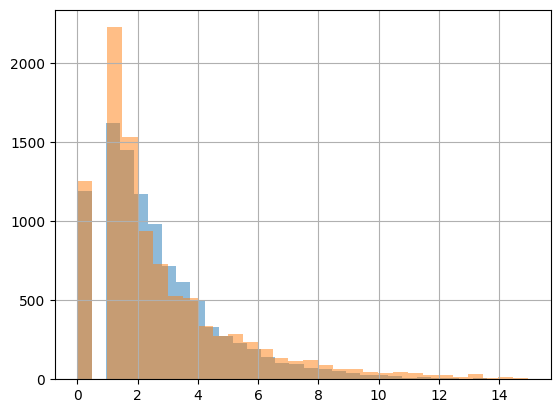

In [8]:
boots_series = pd.Series(rvalues)
rvalues_analitics = mult_values_analitics(zerosratio,10000)
smooth_series = pd.Series(rvalues_analitics)
smooth_series.where(smooth_series<=15).hist(bins=30,alpha=0.5,color='tab:blue')
boots_series.where(boots_series <= 15).hist(bins=30,alpha=0.5,color='tab:orange');

Есть некоторые нестыковки, но для грубых выводов ипользуемого приближения должно хватать.

# Проверка различных стратегий

Все стратегии проверяются схожими по структуре функциями:

    - на вход подается массив исходов
    - на выходе массив возможных исходов

## Стратегия: постоянная ставка на некий коэффициент
Просто ставим 100  руб на постоянный коээфициент K передаваемый как аргумент

In [9]:
@njit
def strategy_const_k (balance: float, k: float)  -> float:
    return k

Разовая симуляция для отладки (и вообще-то в numba хотя бы раз вызвать функцию для компиляции).
Ранний выход из игры не поддерживается как не добавляющий значительных шансов.

In [10]:
start_balance = 5000.0
game_rounds = 100 # продолжительность серии игры
boots_data = df.point.to_numpy()
rvalues = mult_values_bootstrap(game_rounds,boots_data)
k=2.7

@njit
def simulate_one_game(k: float,start_balance: float,game_rounds: int, sequence: np.ndarray) -> float:
    balance = start_balance
    bet = 100 # постоянная сумма ставки 
    bet_rate = strategy_const_k(balance,k) # постоянная стратегия
    for outcome  in sequence:
        balance = balance - bet
        #print('prev:',balance,' ',end='')
        if outcome >= bet_rate and outcome >= 1.01 :
            balance += bet * bet_rate
        #print('outcome',outcome, 'new balance',balance)
    return balance

total = simulate_one_game(k,start_balance, game_rounds, rvalues)
print(total)

4180.0


Серия симуляций для выяснения **распределения** прогнозируемой суммы. 

In [11]:
game_rounds = 5000 # число подходов в одной игре, раз.
number_of_games = 50000 # число симуляций
start_balance= 5000.0 # начальный баланс
boots_data = df.point.to_numpy() # массив данных для bootstrap
k=2.7



@njit(parallel=True)
def simulate_all_games (x: float, game_rounds :int, number_of_games: int) -> np.ndarray :
    game_results = np.zeros(number_of_games)
    for i in range(number_of_games):
        rvalues = mult_values_bootstrap(game_rounds,boots_data)
        game_results[i]=simulate_one_game(x,number_of_games,game_rounds,rvalues)
    return game_results 

game_results=simulate_all_games(2.7,game_rounds,number_of_games)
# Контроль первых 10 результатов 
game_results[0:10]

array([42210., 40320., 47880., 38160., 57870., 61110., 42210., 39240.,
       56520., 45990.])

Теперь можно рассуждать об перспективах в игре с учетом **number_of_games** равновозможных вариантов будущего.

Ожидаемая сумма распределиться по этому графику:

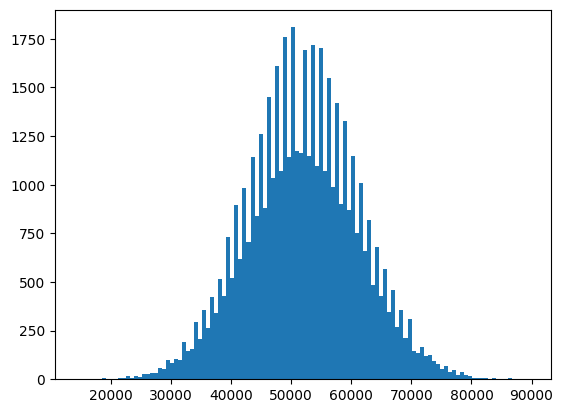

In [12]:
plt.hist(game_results,bins='auto');

In [13]:
print('Начали с ', start_balance, '. В среднем ожидаем выиграть', game_results.mean(), 
      ', но разброс +-',game_results.std())

Начали с  5000.0 . В среднем ожидаем выиграть 51947.5662 , но разброс +- 9221.512769313806


# Поиск оптимального коэффициента 


In [14]:
def find_function(k):
    game_rounds=5000
    number_of_games=50000
    game_results=simulate_all_games(k,game_rounds,number_of_games)
    return -game_results.mean()
vfunc = np.vectorize(find_function)

Отрисуем график в некоторых точках чтобы понять с какой функцией имеем дело. Имеет ли смысл искать коэффициент вообще? 

In [15]:
xs = np.linspace(1.01,15,20)
xs

array([ 1.01      ,  1.74631579,  2.48263158,  3.21894737,  3.95526316,
        4.69157895,  5.42789474,  6.16421053,  6.90052632,  7.63684211,
        8.37315789,  9.10947368,  9.84578947, 10.58210526, 11.31842105,
       12.05473684, 12.79105263, 13.52736842, 14.26368421, 15.        ])

In [16]:
ys = vfunc(xs)
ys

array([  5314.97598   , -49393.17539999, -52301.2147579 , -38889.61250105,
        -6158.47490526,  32608.34931368,  72877.58129474, 118849.74639158,
       154692.41794947, 194508.17965263, 228719.37451579, 264388.98978105,
       293727.19625895, 317772.34073053, 337857.28794211, 351852.14084211,
       365774.44875158, 377604.85194316, 388483.35451789, 395864.61      ])

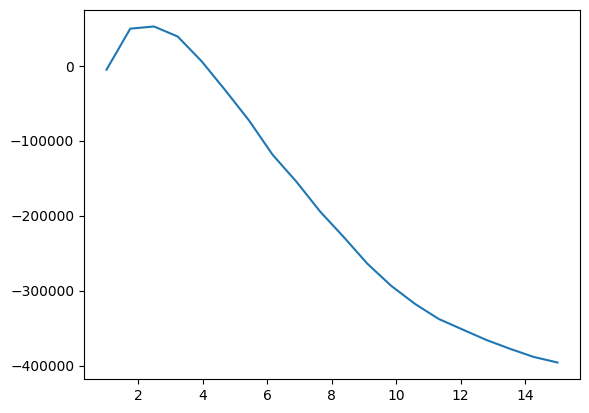

In [17]:
plt.plot(xs,-ys)

Несмотря на опасения связанные с негладкими данными от процедуры bootstrap, 
функция выглядит более-менее гладко.
Попытаемся использовать стандартный метод нахождения максимума.

In [18]:
from scipy.optimize import minimize_scalar

In [21]:
res = minimize_scalar(find_function, 1.5, bounds=(1.01, 15.0), method='bounded')
res

 message: Solution found.
 success: True
  status: 0
     fun: -57122.694839728734
       x: 2.2199993228658577
     nit: 28
    nfev: 28

# Выводы:
  
  -  на размноженных данных тоже показано существование оптимальной беспроигрышной стратегии основанной на постоянной ставке.
  -  маловеорятно, чтобы создатель игры оставил лазейку для создания беспроигрышной стратегии. Скорее всего, игра является обманом и вывод денег затруднен или даже невозможен.